06/03-2025

Running 50 shadow models (LSTM, 10 epochs) on 32 indviduals from EEG.
Train size: 4, Test size: 4 [individuals].

Comparing utility of the different signals on EEG.

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
steps_per_individual = 1315584
feature_names = ["Trend", "Seasonality", "MSE", "MASE", "TS2VecLoss"]
num_features = len(feature_names)

In [3]:
features = np.load("features.npy")
mask = np.load("mask.npy")
num_individuals = features.shape[0] // steps_per_individual

## Plotting distributions

In [4]:
best_per_individual = []
feature_to_sort = 2
for ind in range(num_individuals):
    best_diff = 0
    best_i = -1
    for i in range(ind*steps_per_individual, (ind+1)*steps_per_individual):
        current_mask = np.array(mask[i, :], dtype=bool)
        current_features = features[i, ...]
        ins = current_features[current_mask]
        outs = current_features[np.logical_not(current_mask)]
        
        diff = abs(ins[:, feature_to_sort].mean() - outs[:, feature_to_sort].mean()) / ins[:, feature_to_sort].std()
        if diff > best_diff:
            best_i = i
            best_diff = diff
    best_per_individual.append(best_i)


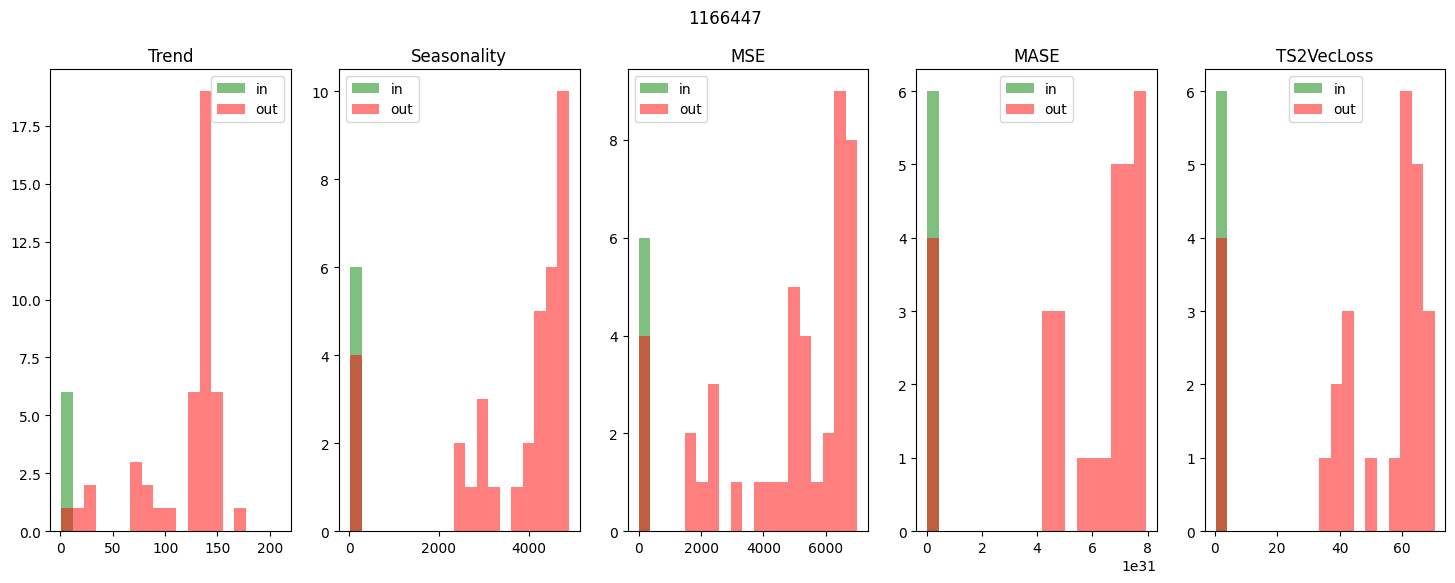

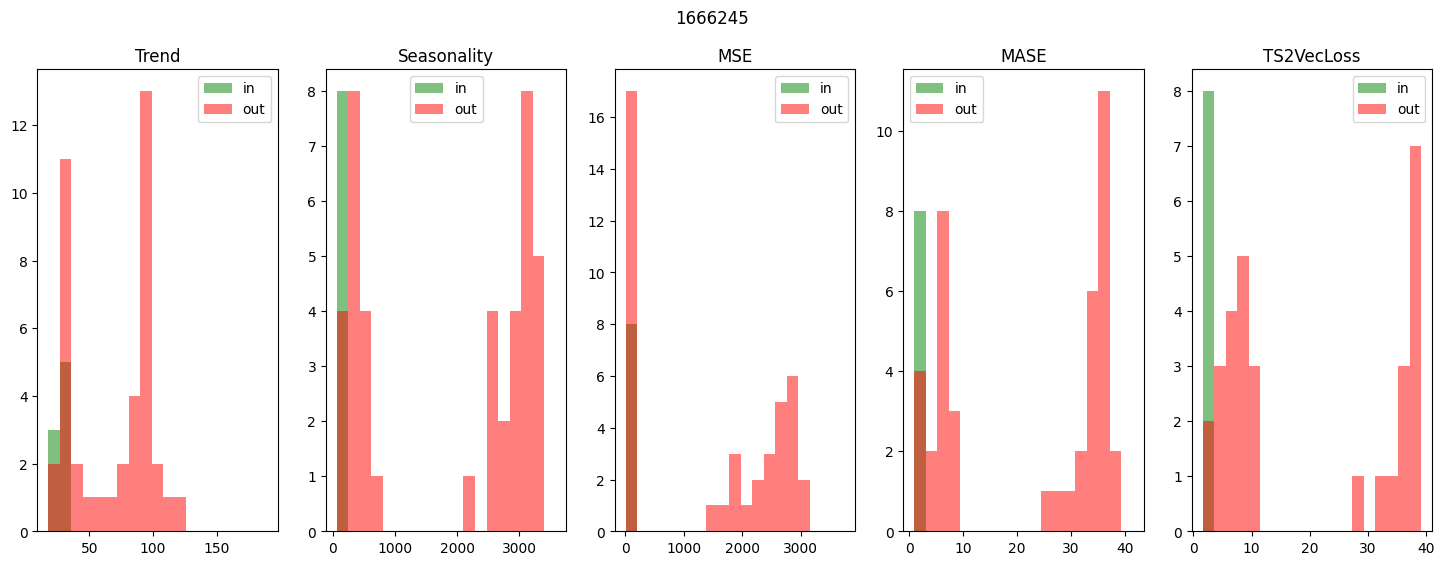

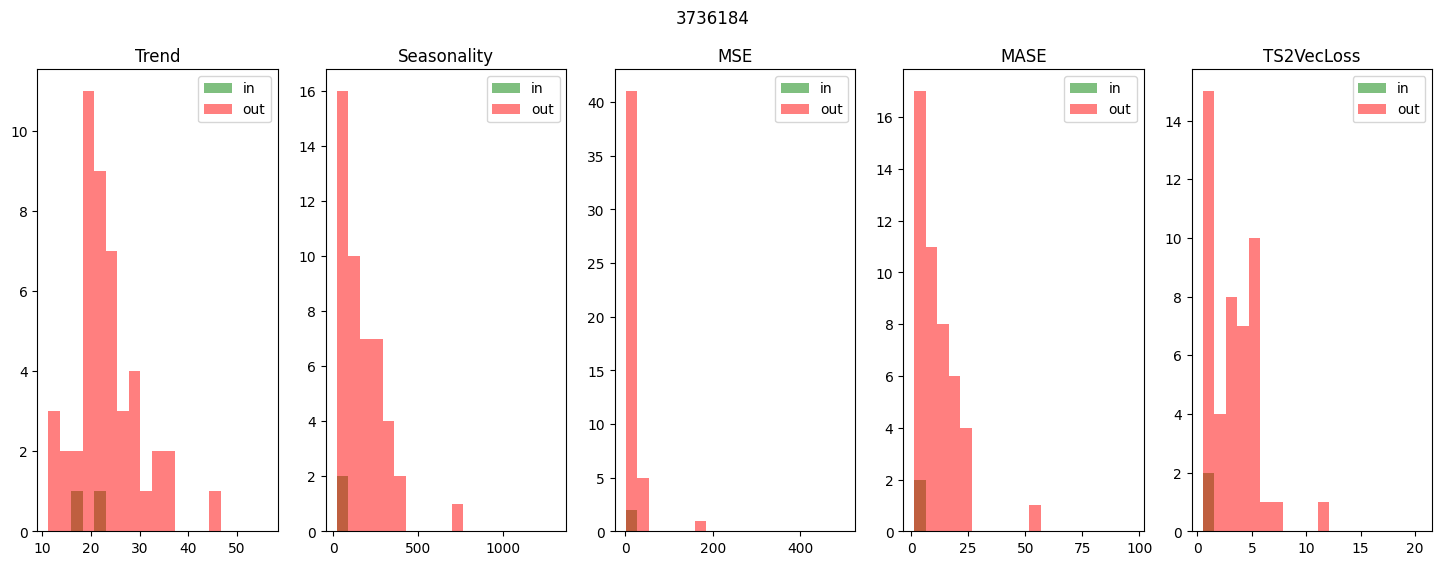

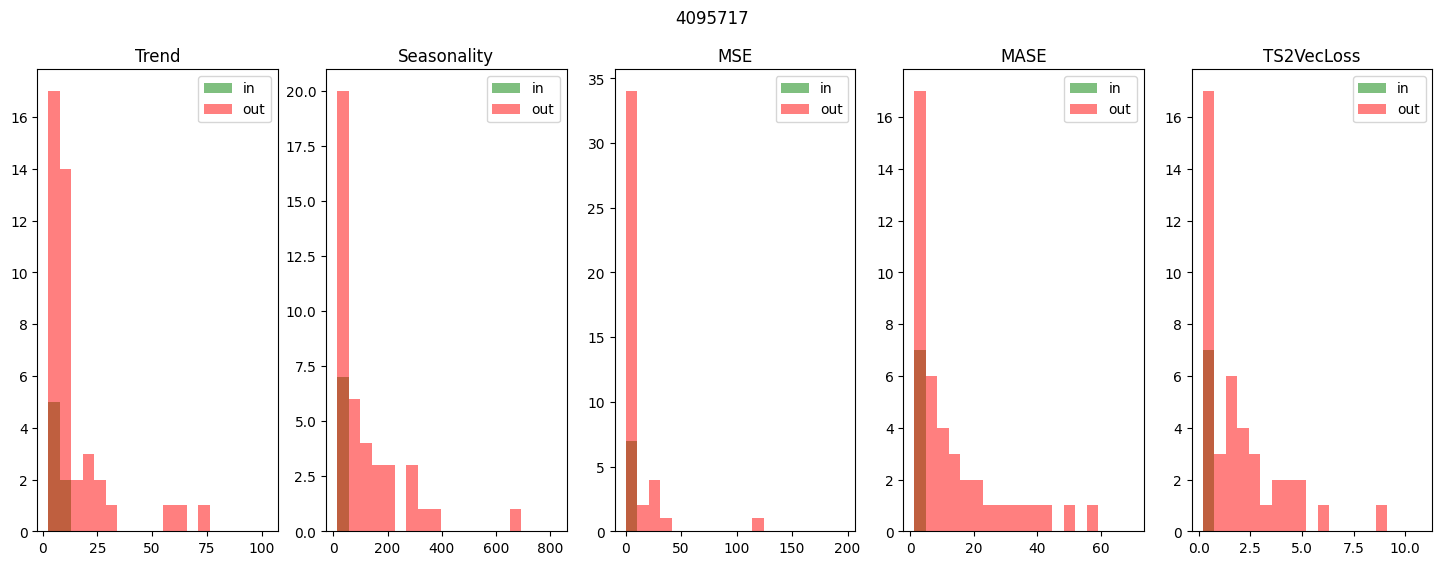

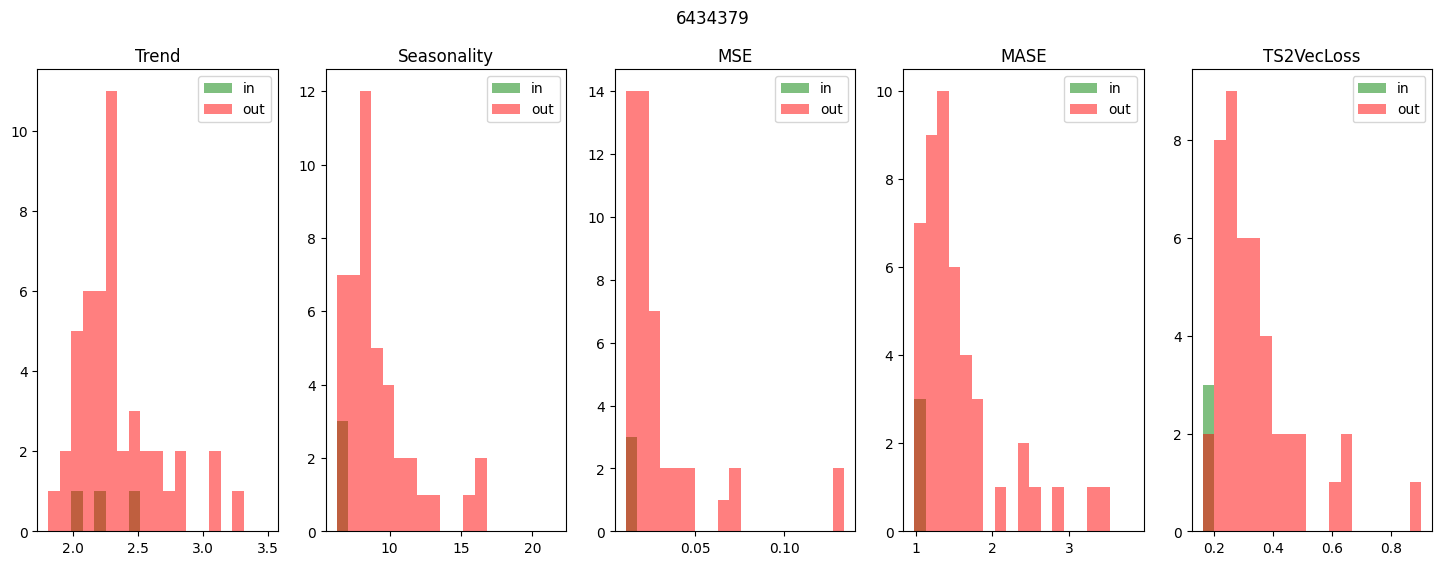

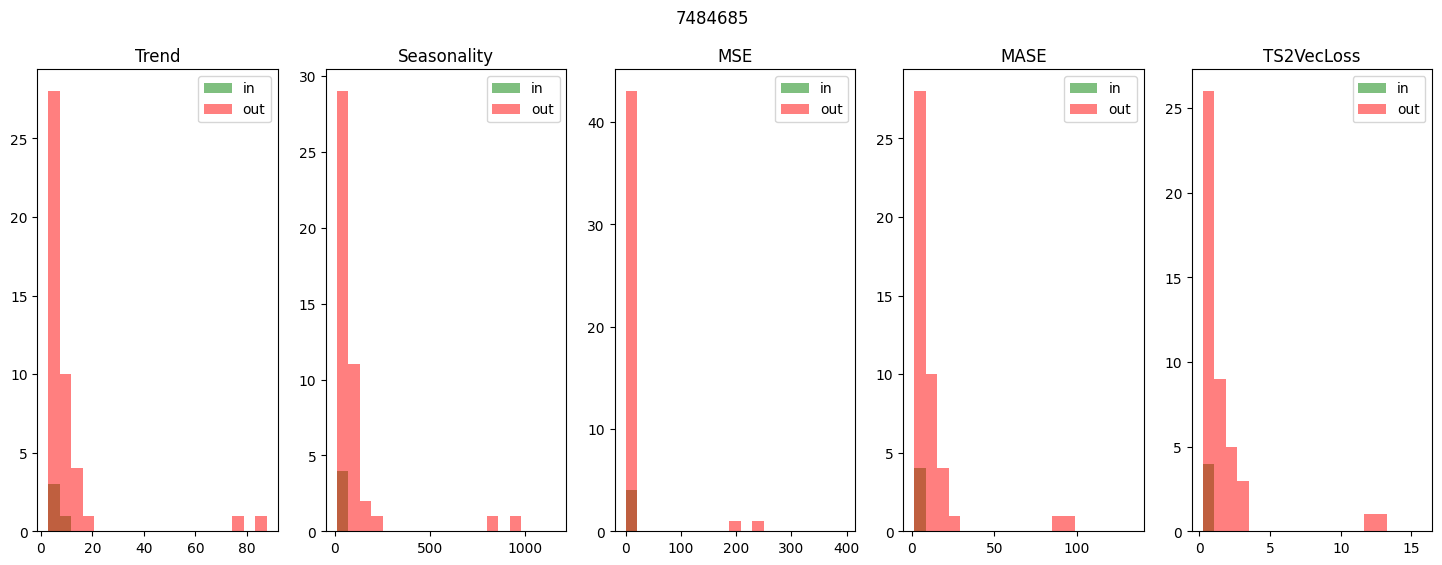

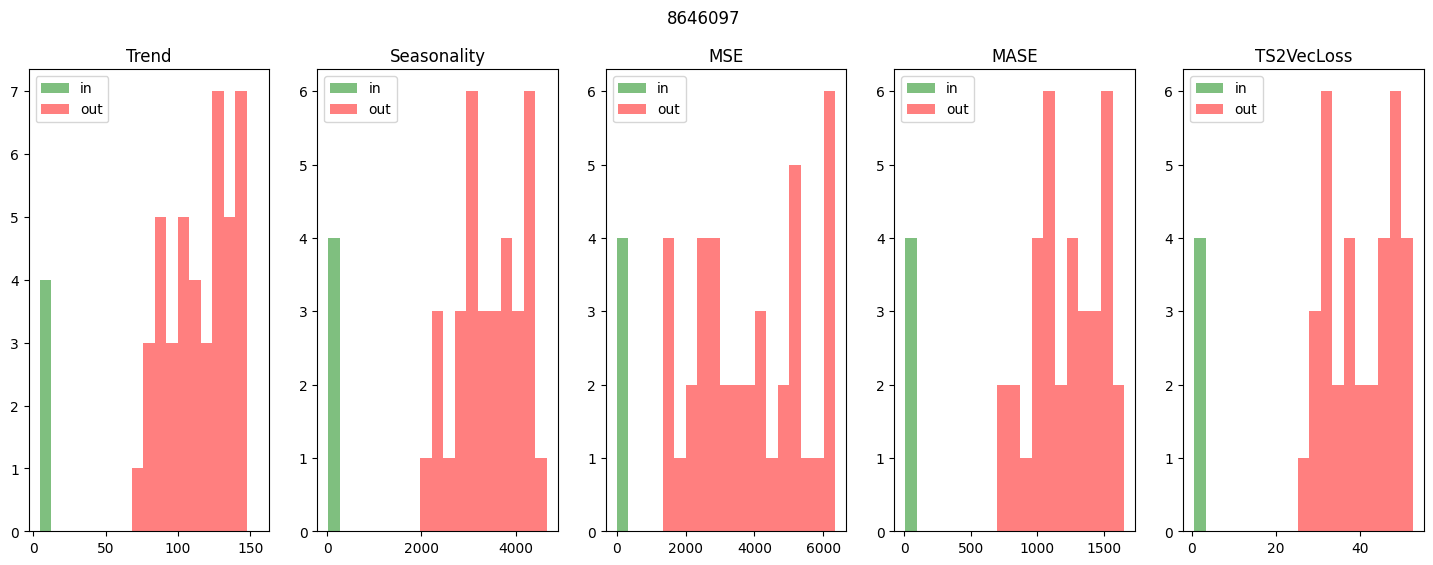

In [5]:
num_plots = 10
for i in best_per_individual:
    fig, axs = plt.subplots(1, num_features)
    fig.set_size_inches(18, 6)
    fig.suptitle(str(i))
    for f in range(num_features):
        ax = axs[f]
        ax.set_title(feature_names[f])
        current_mask = np.array(mask[i, :], dtype=bool)
        current_features = features[i, :, f]
        ins = current_features[current_mask]
        outs = current_features[np.logical_not(current_mask)]
        bins = np.arange(min(current_features), max(current_features), (max(current_features)-min(current_features))/20)
        ax.hist(ins, color="green", alpha=0.5, bins=bins, label="in")
        ax.hist(outs, color="red", alpha=0.5, bins=bins, label="out")
        ax.legend()
        
    plt.show()


## Distribution distances

In [6]:
large_value = 1e10
features[np.isinf(features)] = large_value

In [7]:
def normalize_features(features):
    # Flatten the 3D array to 2D (nsamples * nshadow_models, nfeatures)
    nsamples, nshadow_models, nfeatures = features.shape
    features_reshaped = features.reshape(nsamples * nshadow_models, nfeatures)
    
    # Apply StandardScaler
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features_reshaped)
    
    # Reshape back to 3D array (nsamples, nshadow_models, nfeatures)
    normalized_features = normalized_features.reshape(nsamples, nshadow_models, nfeatures)
    
    return normalized_features

# Bhattacharyya distance by gaussian approximation
def bhattacharyya_distance(x1, x2):
    u1 = np.mean(x1)
    v1 = np.var(x1)
    o1 = np.std(x1)

    u2 = np.mean(x2)
    v2 = np.var(x2)
    o2 = np.std(x2)

    d = (1/4) * ((u1 - u2)**2) / (v1 + v2) + (1/2) * np.log((v1 + v2) / (2*o1*o2))
    return d

def bhattacharyya_distance_per_feature_and_sample(features, mask):
    normalized_features = normalize_features(features)

    num_samples, num_shadow_models, num_features = features.shape
    bscores = np.zeros((num_samples, num_features))

    for i in tqdm(range(num_samples)):
        for f in range(num_features):
            in_values = normalized_features[i, :, f][mask[i, :] == 1]
            out_values = normalized_features[i, :, f][mask[i, :] == 0]
            bscores[i, f] = bhattacharyya_distance(in_values, out_values)

    return bscores

bscores = bhattacharyya_distance_per_feature_and_sample(features, mask)
mean_bscores = np.mean(bscores, axis=0)
mean_bscores_labeled = [f'{name}: {mean_bscores[i]}' for i, name in enumerate(feature_names)]
print("Bhattacharyya distance per feature (averaged over samples):\n", mean_bscores_labeled)

bscores_sorted = np.sort(bscores, axis=0)
num_top_samples = int(np.ceil(1 / 100 * bscores.shape[0]))
top_1percent_values = bscores_sorted[-num_top_samples:, :]
mean_top_1percent_bscores = np.mean(top_1percent_values, axis=0)
mean_top_1percent_bscores_labeled = [f'{name}: {mean_top_1percent_bscores[i]}' for i, name in enumerate(feature_names)]
print("Bhattacharyya distance per feature (mean of top 1%):\n", mean_top_1percent_bscores_labeled)

  0%|          | 204/10524192 [00:00<1:26:14, 2033.74it/s]/tmp/ipykernel_77294/3442775313.py:25: RuntimeWarning: invalid value encountered in scalar divide
  d = (1/4) * ((u1 - u2)**2) / (v1 + v2) + (1/2) * np.log((v1 + v2) / (2*o1*o2))
100%|██████████| 10524192/10524192 [1:28:39<00:00, 1978.45it/s]


Bhattacharyya distance per feature (averaged over samples):
 ['Trend: 0.4360224724011505', 'Seasonality: 0.5613233867601215', 'MSE: 0.7265878113920442', 'MASE: nan', 'TS2VecLoss: 0.5369479174011629']
Bhattacharyya distance per feature (mean of top 1%):
 ['Trend: 5.182830090006354', 'Seasonality: 3.8620943069525335', 'MSE: 4.228605010944295', 'MASE: nan', 'TS2VecLoss: 6.62283226557689']


## Correlation

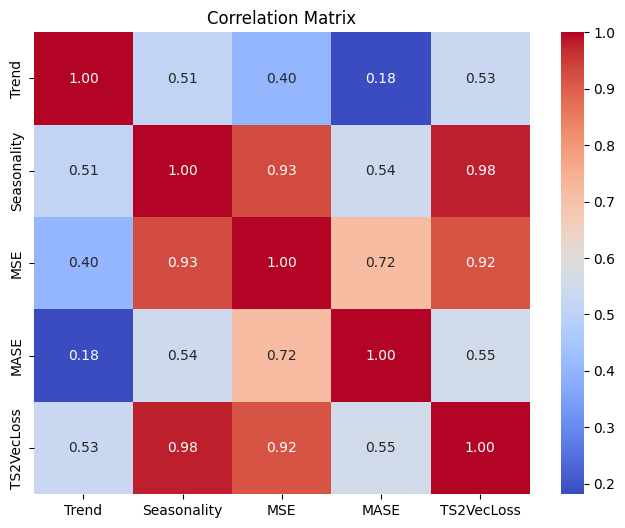

In [10]:
features_2d = features.reshape(-1, num_features)

# Compute correlation matrix
corr_matrix = np.corrcoef(features_2d, rowvar=False)

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    xticklabels=[feature_names[i] for i in range(num_features)], 
    yticklabels=[feature_names[i] for i in range(num_features)]
)
plt.title("Correlation Matrix")
plt.show()